In [1]:
import tensorflow
from tensorflow import keras
from keras.datasets import mnist, cifar10, cifar100
import numpy as np
import matplotlib.pyplot as plot

print('Tensorflow version:',tensorflow.__version__)

Tensorflow version: 2.12.0


---

You can use the function below to load some of the simple datasets available directly from `keras`. There are three options for the `dataset_name` argument:
1. `mnist`: this the dataset Zahari used last week with the handwritten digits from 0 - 9. These images are (28,28,1) in shape
2. `cifar10`: these are small colour images with shape (32,32,3) from ten different classes (plane, car, bird, cat, deer, dog, frog, horse, ship, truck)
3. `cifar100`: as above but with 100 classes! This will not be feasible to use with just a CPU as it would take a fairly complex network with many parameters. I have included it in case you want to play with this on a GPU one day

In [2]:
def load_dataset(dataset_name='mnist'):
  # MNIST, CIFAR10 and CIFAR100 are standard datasets we can load straight
  # from keras. The data are split between train and test sets automatically
  # - x_train is a numpy array that stores the training images
  # - y_train is a numpy array that stores the true class of the training images
  # - x_train is a numpy array that stores the testing images
  # - y_train is a numpy array that stores the true class of the testing images
  if dataset_name.lower() == 'cifar10':
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    n_classes = 10
  elif dataset_name.lower() == 'cifar100':
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()
    n_classes = 100
  elif dataset_name.lower() == 'mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # MNIST is greyscale so we have to do a trick to add a depth dimension
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)
    n_classes = 10
  else:
    print('Requested dataset does not exist. Please choose from mnist, cifar10 or cifar100')
    return

  # Let's check the shape of the images for convenience
  print("Shape of x_train =",x_train.shape)
  print("Shape of x_test =",x_test.shape)

  # The y_train and y_test values we loaded also need to be modified.
  # These values store the true classification of the images (0-9) as a single
  # number. We need to convert the single value into an array of length 10
  # corresponding to the number of output classes. Thus values of
  # y = 2 becomes y = [0,0,1,0,0,0,0,0,0,0]
  # y = 8 becomes y = [0,0,0,0,0,0,0,0,1,0]
  y_train = keras.utils.to_categorical(y_train, n_classes)
  y_test = keras.utils.to_categorical(y_test, n_classes)

  print("Shape of y_train =", y_train.shape)
  print("Shape of y_test =", y_test.shape)

  # Let's take a look at a few example images from the training set
  n_plots=5
  fig, ax = plot.subplots(1, n_plots)
  for plot_number in range (0, n_plots):
    ax[plot_number].imshow(x_train[plot_number])

  return (x_train, y_train), (x_test, y_test), n_classes

---

Here we use the `load_data` function to load our dataset. In the
first instance we will use `mnist` since it is the simplest dataset and we can use a very simple CNN.

170498071/170498071 [==============================] - 4s 0us/step
Shape of x_train = (50000, 32, 32, 3)
Shape of x_test = (10000, 32, 32, 3)
Shape of y_train = (50000, 10)
Shape of y_test = (10000, 10)


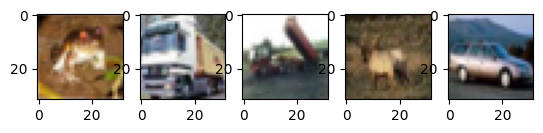

In [12]:
# Load the input data.
# x_train is the training data, and y_train the corresponding true labels
# x_test is the testing data, and y_test the corresponding true labels
# We don't have a separate validation sample in these keras datasets
# Num_classes is the number of true classes
(x_train, y_train), (x_test, y_test), num_classes = load_dataset('cifar10')

---

Now we want to define a CNN. The basic building blocks you will need are:


*   Convolutional layers: `keras.layers.Conv2D(num_filters, (k,k), activation='relu')`. Typical values of `k` are 3, 5, or 7
*   Pooling layers: `keras.layers.MaxPooling2D((2,2))` will perform a factor of 2 downsampling in the two dimensions of image
*   Dropout: keras.layers.Dropout(fraction) where fraction is the fraction of weights that are ignored. Typical values can be 0.25 or 0.5
*   Dense layers: `keras.layers.Dense(num_nodes, activation='relu')` where the num_nodes is how many neurons are in the layer. The final layer of the CNN needs have to have `num_nodes = num_classes`
*   Flatten layer: This just converts and n-dimensional tensor into a vector. In this case we use it to present a dense output layer with a vector input


In the following way of writing our network, we need to write things in the form:

`layer_output = keras.layers.LayerNameHere(arguments_go_here)(layer_input)`


In [16]:
# Define our simplest model first
input_layer = keras.layers.Input(x_train[0].shape)
x = None(input_layer) # Replace None with a 2D convolution with 32 filters of size (3,3) and relu activation
x = None(x) # Replace None with a MaxPooling2D layer to downsample by a factor of 2 in both dimensions
x = None(x) # Replace None with a droput layer with a fraction of 0.25
x = keras.layers.Flatten()(x)
x = None(x) # Replace None with a final dense output layer with num_classes neurons
cnn_model = keras.Model(input_layer, x)
cnn_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 flatten_3 (Flatten)         (None, 6272)              0         
                                                           

In [17]:
# The batch size controls the number of images that are processed simultaneously
batch_size = 128
# The number of epochs that we want to train the network for
epochs = 5
# The learning rate (step size in gradient descent)
learning_rate = 0.001
# Define the loss function and optimiser and then compile the model
loss_function = keras.losses.categorical_crossentropy
optimiser = keras.optimizers.Adam(learning_rate=learning_rate)
cnn_model.compile(loss=loss_function, optimizer=optimiser, metrics=['accuracy'])

Now we can run our network on whichever data sample we requested. Initially on `mnist` we'll hopefully see that we can reach a very high accuracy.

In [18]:
# Train the model using the training data with the true target outputs
cnn_model.fit(x_train, y_train,
          batch_size = batch_size,
          epochs = epochs,
          verbose = 1,
          validation_data = (x_test, y_test))


Epoch 1/5
391/391 [==============================] - 127s 323ms/step - loss: 3.1533 - accuracy: 0.2782 - val_loss: 1.6564 - val_accuracy: 0.4002
Epoch 2/5
391/391 [==============================] - 124s 317ms/step - loss: 1.6361 - accuracy: 0.4165 - val_loss: 1.4545 - val_accuracy: 0.4813
Epoch 3/5
391/391 [==============================] - 125s 319ms/step - loss: 1.4305 - accuracy: 0.4909 - val_loss: 1.3506 - val_accuracy: 0.5294
Epoch 4/5
391/391 [==============================] - 125s 321ms/step - loss: 1.3250 - accuracy: 0.5319 - val_loss: 1.3369 - val_accuracy: 0.5286
Epoch 5/5
391/391 [==============================] - 126s 321ms/step - loss: 1.2636 - accuracy: 0.5581 - val_loss: 1.2663 - val_accuracy: 0.5560


In [8]:
# Make a list of incorrect classifications
incorrect_indices = []
# By default, let's check one thousand images from x_test.
# You can check more, up to the value of testing_size.
n_images_to_check = x_test.shape[0]
# Use the CNN to predict the classification of the images. It returns an array
# containing the 10 class scores for each image. Remember to use the x[:n]
# notation mentioned above in the following function call
raw_predictions = cnn_model.predict(x_test[:n_images_to_check])
for i in range(0,n_images_to_check):
  # Remember the raw output from the CNN gives us an array of scores. We want
  # to select the highest one as our prediction. We need to do the same thing
  # for the truth too since we converted our numbers to a categorical
  # representation earlier. We use the np.argmax() function for this
  prediction = np.argmax(raw_predictions[i])
  truth = np.argmax(y_test[i])
  if prediction != truth:
    incorrect_indices.append([i,prediction,truth])
print('Number of images that were incorrectly classified =',len(incorrect_indices))

313/313 [==============================] - 2s 5ms/step
Number of images that were incorrectly classified = 203


Incorrect classification for image 247 : predicted = 6 with true = 4


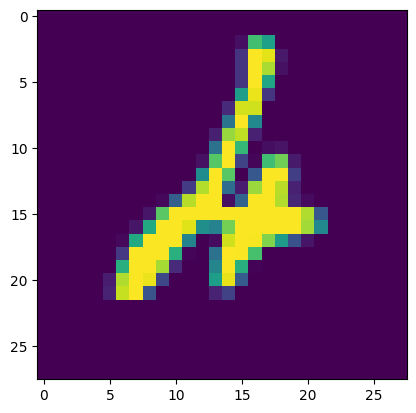

In [11]:
# Now you can modify this part to draw different images from the failures list
# You can change the value of im to look at different failures
im = 1
image_to_plot = x_test[incorrect_indices[im][0]]
fig, ax = plot.subplots(1, 1)
print('Incorrect classification for image',incorrect_indices[im][0],
      ': predicted =',incorrect_indices[im][1],
      'with true =',incorrect_indices[im][2])
ax.imshow(image_to_plot)